# Time Series: Investigate Currency Exchange History £ --> €
## Data: https://www.ofx.com/
## Load libraries and read datafile 

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource

In [62]:
fn = 'ofx-GBP-EUR-2.xlsx'
data = pd.read_excel(fn)
df_fx = pd.DataFrame(data)
df_fx.head()

,Date,Conversion
0,2008-05-07,1.270219
1,2008-05-08,1.269209
2,2008-05-09,1.269134
3,2008-05-10,1.269134
4,2008-05-11,1.269134


### Data Pre-processing
#### $\color{blue}{\text{For some conversion rates the digit seems to have shifted by one, e.g}}$

In [63]:
df_fx[13:16]

,Date,Conversion
13,2008-05-20,1.255727
14,2008-05-21,0.125716
15,2008-05-22,1.247786


$\color{blue}{\text{Option 1: Delete all values < 0.5}}$

In [64]:
df_fx_option1 = df_fx[df_fx.Conversion >0.5]
print(df_fx.shape)
print(df_fx_option1.shape)

(3628, 2)
(3258, 2)


$\color{blue}{\text{Option 2 (with which we will continue): Multiply all values < 0.5 with 10}}$

In [65]:
def multi(x):
    if x < 0.5:
        return(x * 10)
    else:
        return x
    
df_fx['Conversion_op2'] = df_fx['Conversion'].apply(multi)
    

In [66]:
df_fx[13:16]

,Date,Conversion,Conversion_op2
13,2008-05-20,1.255727,1.255727
14,2008-05-21,0.125716,1.257160
15,2008-05-22,1.247786,1.247786


$\color{red}{\text{!!! For some values, even this operation leaves the value below 1.}}$

In [67]:
df_fx[df_fx['Conversion_op2'] < 1].head()

,Date,Conversion,Conversion_op2
113,2008-08-28,0.012473,0.12473
302,2009-03-05,0.011221,0.11221
434,2009-07-15,0.011684,0.11684
435,2009-07-16,0.011649,0.11649
680,2010-03-18,0.011151,0.11151


$\color{red}{\text{These will be treated as artefacts and deleted from the dataset:}}$

In [68]:
df_fx = df_fx[df_fx.Conversion_op2 > 1]

In [69]:
df_fx.head()

,Date,Conversion,Conversion_op2
0,2008-05-07,1.270219,1.270219
1,2008-05-08,1.269209,1.269209
2,2008-05-09,1.269134,1.269134
3,2008-05-10,1.269134,1.269134
4,2008-05-11,1.269134,1.269134


### Extra columns showing year, month and day separately

In [70]:
df_fx['Year'], df_fx['Month'], df_fx['Day'] = (df_fx['Date'].dt.year, 
                                               df_fx['Date'].dt.month, 
                                               df_fx['Date'].dt.day)

In [71]:
df_fx.head()

,Date,Conversion,Conversion_op2,Year,Month,Day
0,2008-05-07,1.270219,1.270219,2008,5,7
1,2008-05-08,1.269209,1.269209,2008,5,8
2,2008-05-09,1.269134,1.269134,2008,5,9
3,2008-05-10,1.269134,1.269134,2008,5,10
4,2008-05-11,1.269134,1.269134,2008,5,11


## Split dataframe into 2, i.e. pre- and post-brexit 

In [72]:
date_of_ref = '2016-06-23' # Date of Referendum
df_fx_pre = df_fx[df_fx['Date'] <= date_of_ref]
df_fx_post = df_fx[df_fx['Date'] > date_of_ref]

In [73]:
print(df_fx_pre.tail())
print(df_fx_post.head())

           Date  Conversion  Conversion_op2  Year  Month  Day
2949 2016-06-19    1.273384        1.273384  2016      6   19
2950 2016-06-20    1.273338        1.273338  2016      6   20
2951 2016-06-21    1.296336        1.296336  2016      6   21
2952 2016-06-22    1.302646        1.302646  2016      6   22
2953 2016-06-23    1.297159        1.297159  2016      6   23
           Date  Conversion  Conversion_op2  Year  Month  Day
2954 2016-06-24    1.305769        1.305769  2016      6   24
2955 2016-06-25    1.228998        1.228998  2016      6   25
2956 2016-06-26    1.230365        1.230365  2016      6   26
2957 2016-06-27    1.230365        1.230365  2016      6   27
2958 2016-06-28    1.196887        1.196887  2016      6   28


## Re-organize dataframe with having month-day combination as index 

In [75]:
def get_monthday(dt):
   return dt.strftime('%m%d')

df_fx_pre['Month-Day'] = df_fx_pre['Date'].apply(get_monthday)
df_fx_post['Month-Day'] = df_fx_post['Date'].apply(get_monthday)
fx_pre = df_fx_pre[['Conversion_op2', 'Year', 'Month-Day']].set_index(['Month-Day', 'Year']).unstack(1)
fx_post = df_fx_post[['Conversion_op2', 'Year', 'Month-Day']].set_index(['Month-Day', 'Year']).unstack(1)

C:\Users\DataCoach\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\DataCoach\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [116]:
x = fx_pre.index.values

In [96]:
fx_pre.head()

Conversion_op2                                                    \
Year                2008      2009      2010      2011      2012      2013   
Month-Day                                                                    
0101                 NaN  1.039724  1.128197  1.164769  1.197892  1.232354   
0102                 NaN  1.043783  1.120105  1.165938  1.197892  1.229838   
0103                 NaN  1.043783  1.121027  1.160178  1.199120  1.231857   
0104                 NaN  1.043783  1.121027  1.159097  1.198654  1.231853   
0105                 NaN  1.045309  1.117052  1.170850  1.208667  1.228956   

                                         
Year           2014      2015      2016  
Month-Day                                
0101       1.203232       NaN  1.357325  
0102       1.205049       NaN  1.357310  
0103       1.202008       NaN  1.357561  
0104       1.206721  1.277028  1.357561  
0105       1.208091  1.277028  1.360186

## Plots (tbd)

In [155]:
# matplotlib
#plt.plot(x, y, color = 'r')
#plt.grid(axis = 'y', color='black', linestyle='--', linewidth=0.1)
#plt.xlabel('Date')
#plt.ylabel('Conversion Rate')
#plt.title('Conversion Rate £ --> €', fontweight="bold")

In [156]:
# fx_pre['Conversion_op2'][[2014, 2015, 2016]].plot()
# fx_post['Conversion_op2'][[2016, 2017, 2018]].plot()

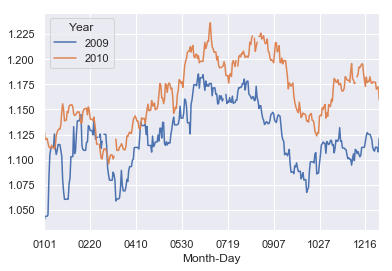

In [183]:
fx_pre['Conversion_op2'][[2009, 2010]].plot()